In [301]:
import torch
from torch import nn

In [302]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [303]:
device

'cuda'

In [304]:
from zipfile import ZipFile
import requests
from pathlib import Path
import os

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir() :
    print("Folder already exist,no need to download")
else:
    data_path.mkdir(parents=True,exist_ok=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading data...")
        res = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
        )
        f.write(res.content)

    with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zf:
        print("Extract file...")
        zf.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

Folder already exist,no need to download


In [305]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [306]:
import os

for dirpath,dirnames,filenames in os.walk(train_dir):
    print(f"on {dirpath} has {len(dirnames)} directories and {len(filenames)} files")

on data\pizza_steak_sushi\train has 3 directories and 0 files
on data\pizza_steak_sushi\train\pizza has 0 directories and 154 files
on data\pizza_steak_sushi\train\steak has 0 directories and 146 files
on data\pizza_steak_sushi\train\sushi has 0 directories and 150 files


In [307]:
## Manual Transforms
from torchvision.transforms import v2

from torchvision.transforms.functional import InterpolationMode


manual_transforms = v2.Compose(

    [

        v2.ToImage(),

        v2.Resize(size=(256, 256), interpolation=InterpolationMode.BICUBIC),

        v2.CenterCrop(size=(224, 224)),

        v2.ToDtype(dtype=torch.float32, scale=True),

        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ]
)

In [308]:
## Auto Transforms
from torchvision.models.efficientnet import EfficientNet_B0_Weights

weights  = EfficientNet_B0_Weights.DEFAULT

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [309]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [310]:
BATCH_SIZE = 32

In [311]:
from going_modular.data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir, test_dir, manual_transforms, auto_transforms, BATCH_SIZE
)

len(train_dataloader)

15

In [312]:
from torchvision.models.efficientnet import efficientnet_b0,EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights).to(device=device)

In [313]:
from torchinfo import summary

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              True
│    │    └─MBConv (0)                              

In [314]:
for param in model.features.parameters():
    param.requires_grad = False

In [315]:
summary(
    model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [316]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)


model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [317]:
summary(
    model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [318]:
from torchmetrics.classification import Accuracy

loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass",num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [319]:
from going_modular.engine import train_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = train_model(model,train_dataloader,test_dataloader,loss_fn,acc_fn,optimizer,device,5)



Epoch: 0


Train Loss: 0.9809 | Train Acc: 0.5933
Test Loss: 0.6760 | Test Acc: 0.8467

Epoch: 1


Train Loss: 0.7335 | Train Acc: 0.8044
Test Loss: 0.5765 | Test Acc: 0.8800

Epoch: 2


Train Loss: 0.6016 | Train Acc: 0.8556
Test Loss: 0.4850 | Test Acc: 0.8867

Epoch: 3


Train Loss: 0.5056 | Train Acc: 0.8689
Test Loss: 0.4465 | Test Acc: 0.8867

Epoch: 4


Train Loss: 0.4902 | Train Acc: 0.8933
Test Loss: 0.4088 | Test Acc: 0.9000


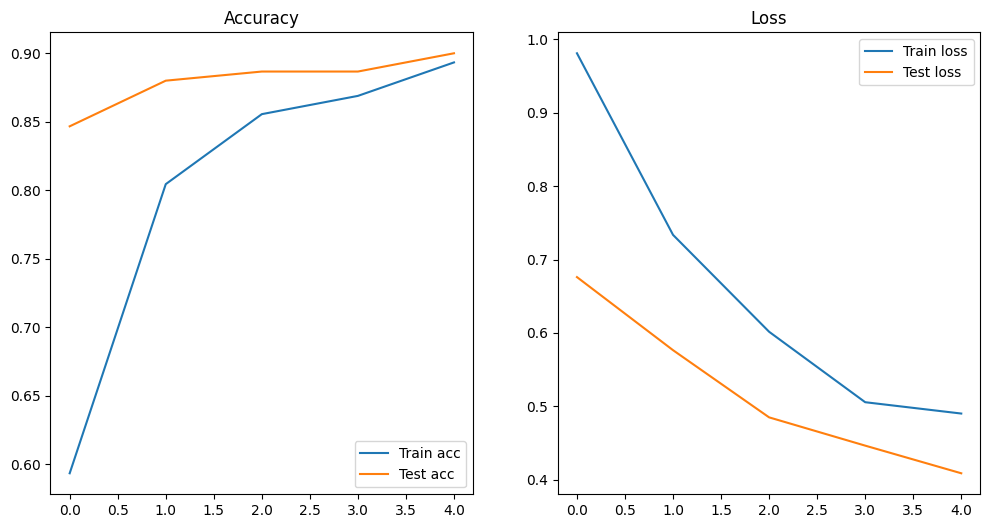

In [321]:
from going_modular.utils import plot_results
plot_results(results)

In [ ]:
from going_modular.engine import train_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_train_longer = train_model(
    model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, device, 15
)

In [ ]:
from going_modular.utils import plot_results

plot_results(results_train_longer)